# Spotify Genre Classifier

## Setup

In [8]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import walk, path

In [9]:
# load data

# get all filenames from the directory data
f = []
for (dirpath, dirnames, filenames) in walk("data"):
    f.extend(filenames)
    break

# load data from all files from the directory data
frames = []
for file in f:
    data = pd.read_json(path.join("data", file))
    frames.append(data)

# concat all data into one dataframe
raw_data = pd.concat(frames, ignore_index=True)

## Visualization

### Clean Dataset

In [10]:
raw_data.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,genre
0,0.1930,0.11600,9,-25.718,1,0.0608,0.986,0.91800,0.5050,0.0836,143.301,audio_features,6pV1dGidc6DvzjKhbMqgDa,spotify:track:6pV1dGidc6DvzjKhbMqgDa,https://api.spotify.com/v1/tracks/6pV1dGidc6Dv...,https://api.spotify.com/v1/audio-analysis/6pV1...,242467,3,classic
1,0.3210,0.00611,4,-38.341,0,0.0362,0.995,0.90800,0.0900,0.0693,104.311,audio_features,1YcABWwgkfrOSw8VMgDWZU,spotify:track:1YcABWwgkfrOSw8VMgDWZU,https://api.spotify.com/v1/tracks/1YcABWwgkfrO...,https://api.spotify.com/v1/audio-analysis/1YcA...,205493,4,classic
2,0.4480,0.00520,4,-36.512,1,0.0564,0.995,0.88000,0.0698,0.0398,62.171,audio_features,1juisCcrVdwoLbDWyVvNrX,spotify:track:1juisCcrVdwoLbDWyVvNrX,https://api.spotify.com/v1/tracks/1juisCcrVdwo...,https://api.spotify.com/v1/audio-analysis/1jui...,369027,4,classic
3,0.4250,0.03630,1,-21.629,0,0.0686,0.991,0.00109,0.2500,0.7450,78.991,audio_features,1AKdBq4wtJKU9DhQpekvtc,spotify:track:1AKdBq4wtJKU9DhQpekvtc,https://api.spotify.com/v1/tracks/1AKdBq4wtJKU...,https://api.spotify.com/v1/audio-analysis/1AKd...,143777,4,classic
4,0.0748,0.04420,0,-19.183,1,0.0426,0.957,0.94000,0.1160,0.0369,79.092,audio_features,5X5x6oRSCHtHEz28ncMVd5,spotify:track:5X5x6oRSCHtHEz28ncMVd5,https://api.spotify.com/v1/tracks/5X5x6oRSCHtH...,https://api.spotify.com/v1/audio-analysis/5X5x...,348907,4,classic


In [11]:
raw_data.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature', 'genre'],
      dtype='object')

In [54]:
# now drop some features which have no importance for the ML task
data = raw_data.drop(["uri", "id", "track_href", "analysis_url", "type"], axis=1)

In [13]:
data.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature', 'genre'],
      dtype='object')

In [14]:
data.shape

(1515, 14)

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1515 entries, 0 to 1514
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      1515 non-null   float64
 1   energy            1515 non-null   float64
 2   key               1515 non-null   int64  
 3   loudness          1515 non-null   float64
 4   mode              1515 non-null   int64  
 5   speechiness       1515 non-null   float64
 6   acousticness      1515 non-null   float64
 7   instrumentalness  1515 non-null   float64
 8   liveness          1515 non-null   float64
 9   valence           1515 non-null   float64
 10  tempo             1515 non-null   float64
 11  duration_ms       1515 non-null   int64  
 12  time_signature    1515 non-null   int64  
 13  genre             1515 non-null   object 
dtypes: float64(9), int64(4), object(1)
memory usage: 165.8+ KB


In [16]:
data.genre.unique()

array(['classic', 'edm', 'hiphop', 'jazz', 'rock'], dtype=object)

In [17]:
data.duration_ms /= 1000
data.rename(columns={"duration_ms": "duration_s"}, inplace=True)

In [61]:
# adding minimum loudness to all loudness values so that there are not any negative values
min_loudness = data.loudness.min()
if(min_loudness < 0):
    data.loudness = data.loudness + abs(min_loudness)
print("Minimum loudness:", data.loudness.min())

Minimum loudness: 0.0


In [18]:
# remove samples with key == -1
print(f"Removed samples: {len(data[data.key == -1])}")
data = data[data.key != -1]

Removed samples: 0


In [19]:
# remove samples where time_signature is out of bounds [3:7]
print(f"Removed samples: {len(data[(data.time_signature < 3) | (data.time_signature > 7)])}")
data = data[(data.time_signature >= 3) & (data.time_signature <= 7)]

Removed samples: 19


In [20]:
sum(data.tempo < 40)

0

### Statistics

In [21]:
# if you want to compare statistic informations from specific features you can use: data.groupby('genre').describe()["feature1", "feature2", ...]
data.groupby('genre').describe()["duration_s"]

,count,mean,std,min,25%,50%,75%,max
genre,,,,,,,,
classic,280.0,343.427054,205.391045,84.267,194.99950,283.2865,424.73975,1252.322
edm,303.0,233.051099,80.152613,123.500,177.70350,211.8680,252.51800,489.480
hiphop,325.0,245.242917,41.930100,104.591,220.29300,245.1330,273.65900,357.200
jazz,292.0,318.743442,128.651265,116.147,204.36325,306.6415,403.43000,733.067
rock,296.0,230.940986,53.013975,110.093,195.64875,218.9265,257.86725,510.933


In [22]:
data.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_s,time_signature
count,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000
mean,0.518864,0.576181,5.324866,-10.743261,0.554813,0.101637,0.359781,0.244451,0.181888,0.405590,118.611152,272.666860,3.922460
std,0.209155,0.328465,3.553143,8.596414,0.497153,0.103556,0.403647,0.369033,0.143416,0.259752,31.233030,124.525156,0.338208
min,0.061800,0.002090,0.000000,-44.526000,0.000000,0.025000,0.000002,0.000000,0.023400,0.027100,47.362000,84.267000,3.000000
25%,0.375000,0.271750,2.000000,-14.000250,0.000000,0.040475,0.010200,0.000000,0.092575,0.167000,93.895250,195.917000,4.000000
50%,0.516500,0.678000,5.000000,-7.225500,1.000000,0.052400,0.108500,0.000865,0.122000,0.387000,116.799500,237.862000,4.000000
75%,0.667000,0.864000,8.000000,-4.709500,1.000000,0.112000,0.838250,0.618250,0.234250,0.616000,145.010500,304.056750,4.000000
max,0.964000,0.998000,11.000000,-0.100000,1.000000,0.944000,0.996000,0.981000,0.972000,0.958000,206.247000,1252.322000,5.000000


### Plot

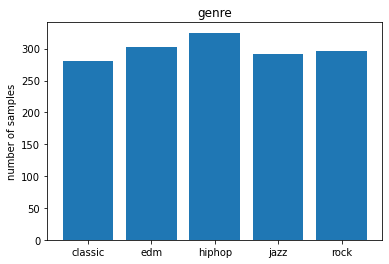

In [23]:
# get all numeric features
numeric_features = data.describe().columns

# get all features
all_features = data.columns

# get all categorical features 
categorical_features = set(all_features) - set(numeric_features)

for col in categorical_features:
  sorted_list = data[col].value_counts().sort_values().sort_index() # get the feature sorted
  labels = sorted_list.index.tolist()
  values = sorted_list.tolist()

  plt.bar(labels, values)
  plt.title(col)
  plt.ylabel("number of samples")
  plt.show()

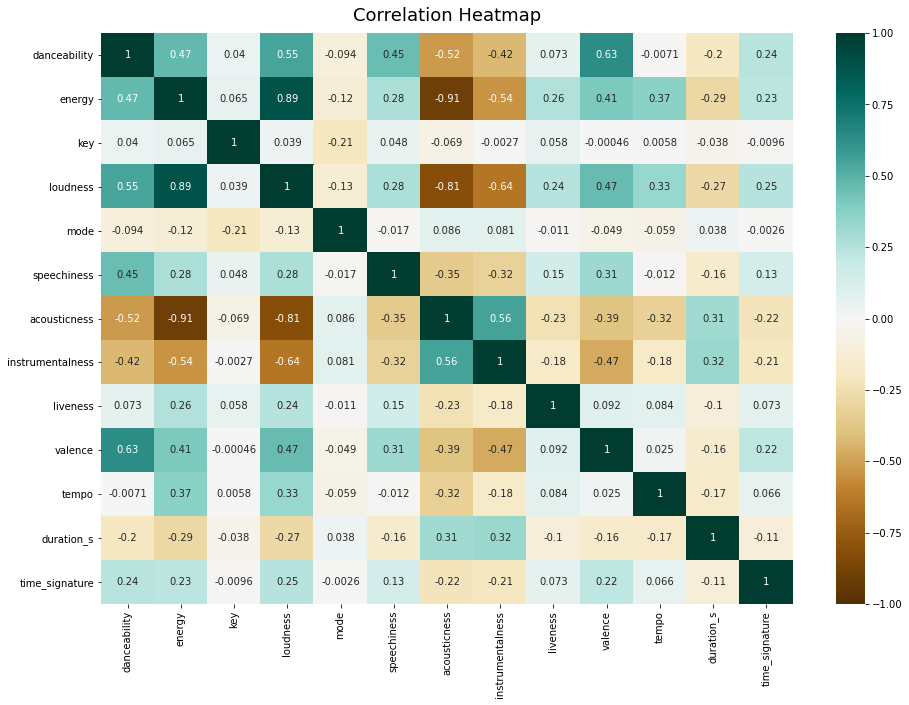

In [25]:
fig = plt.figure()
heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)
fig.set_size_inches(15.5, 10.5, forward=True)

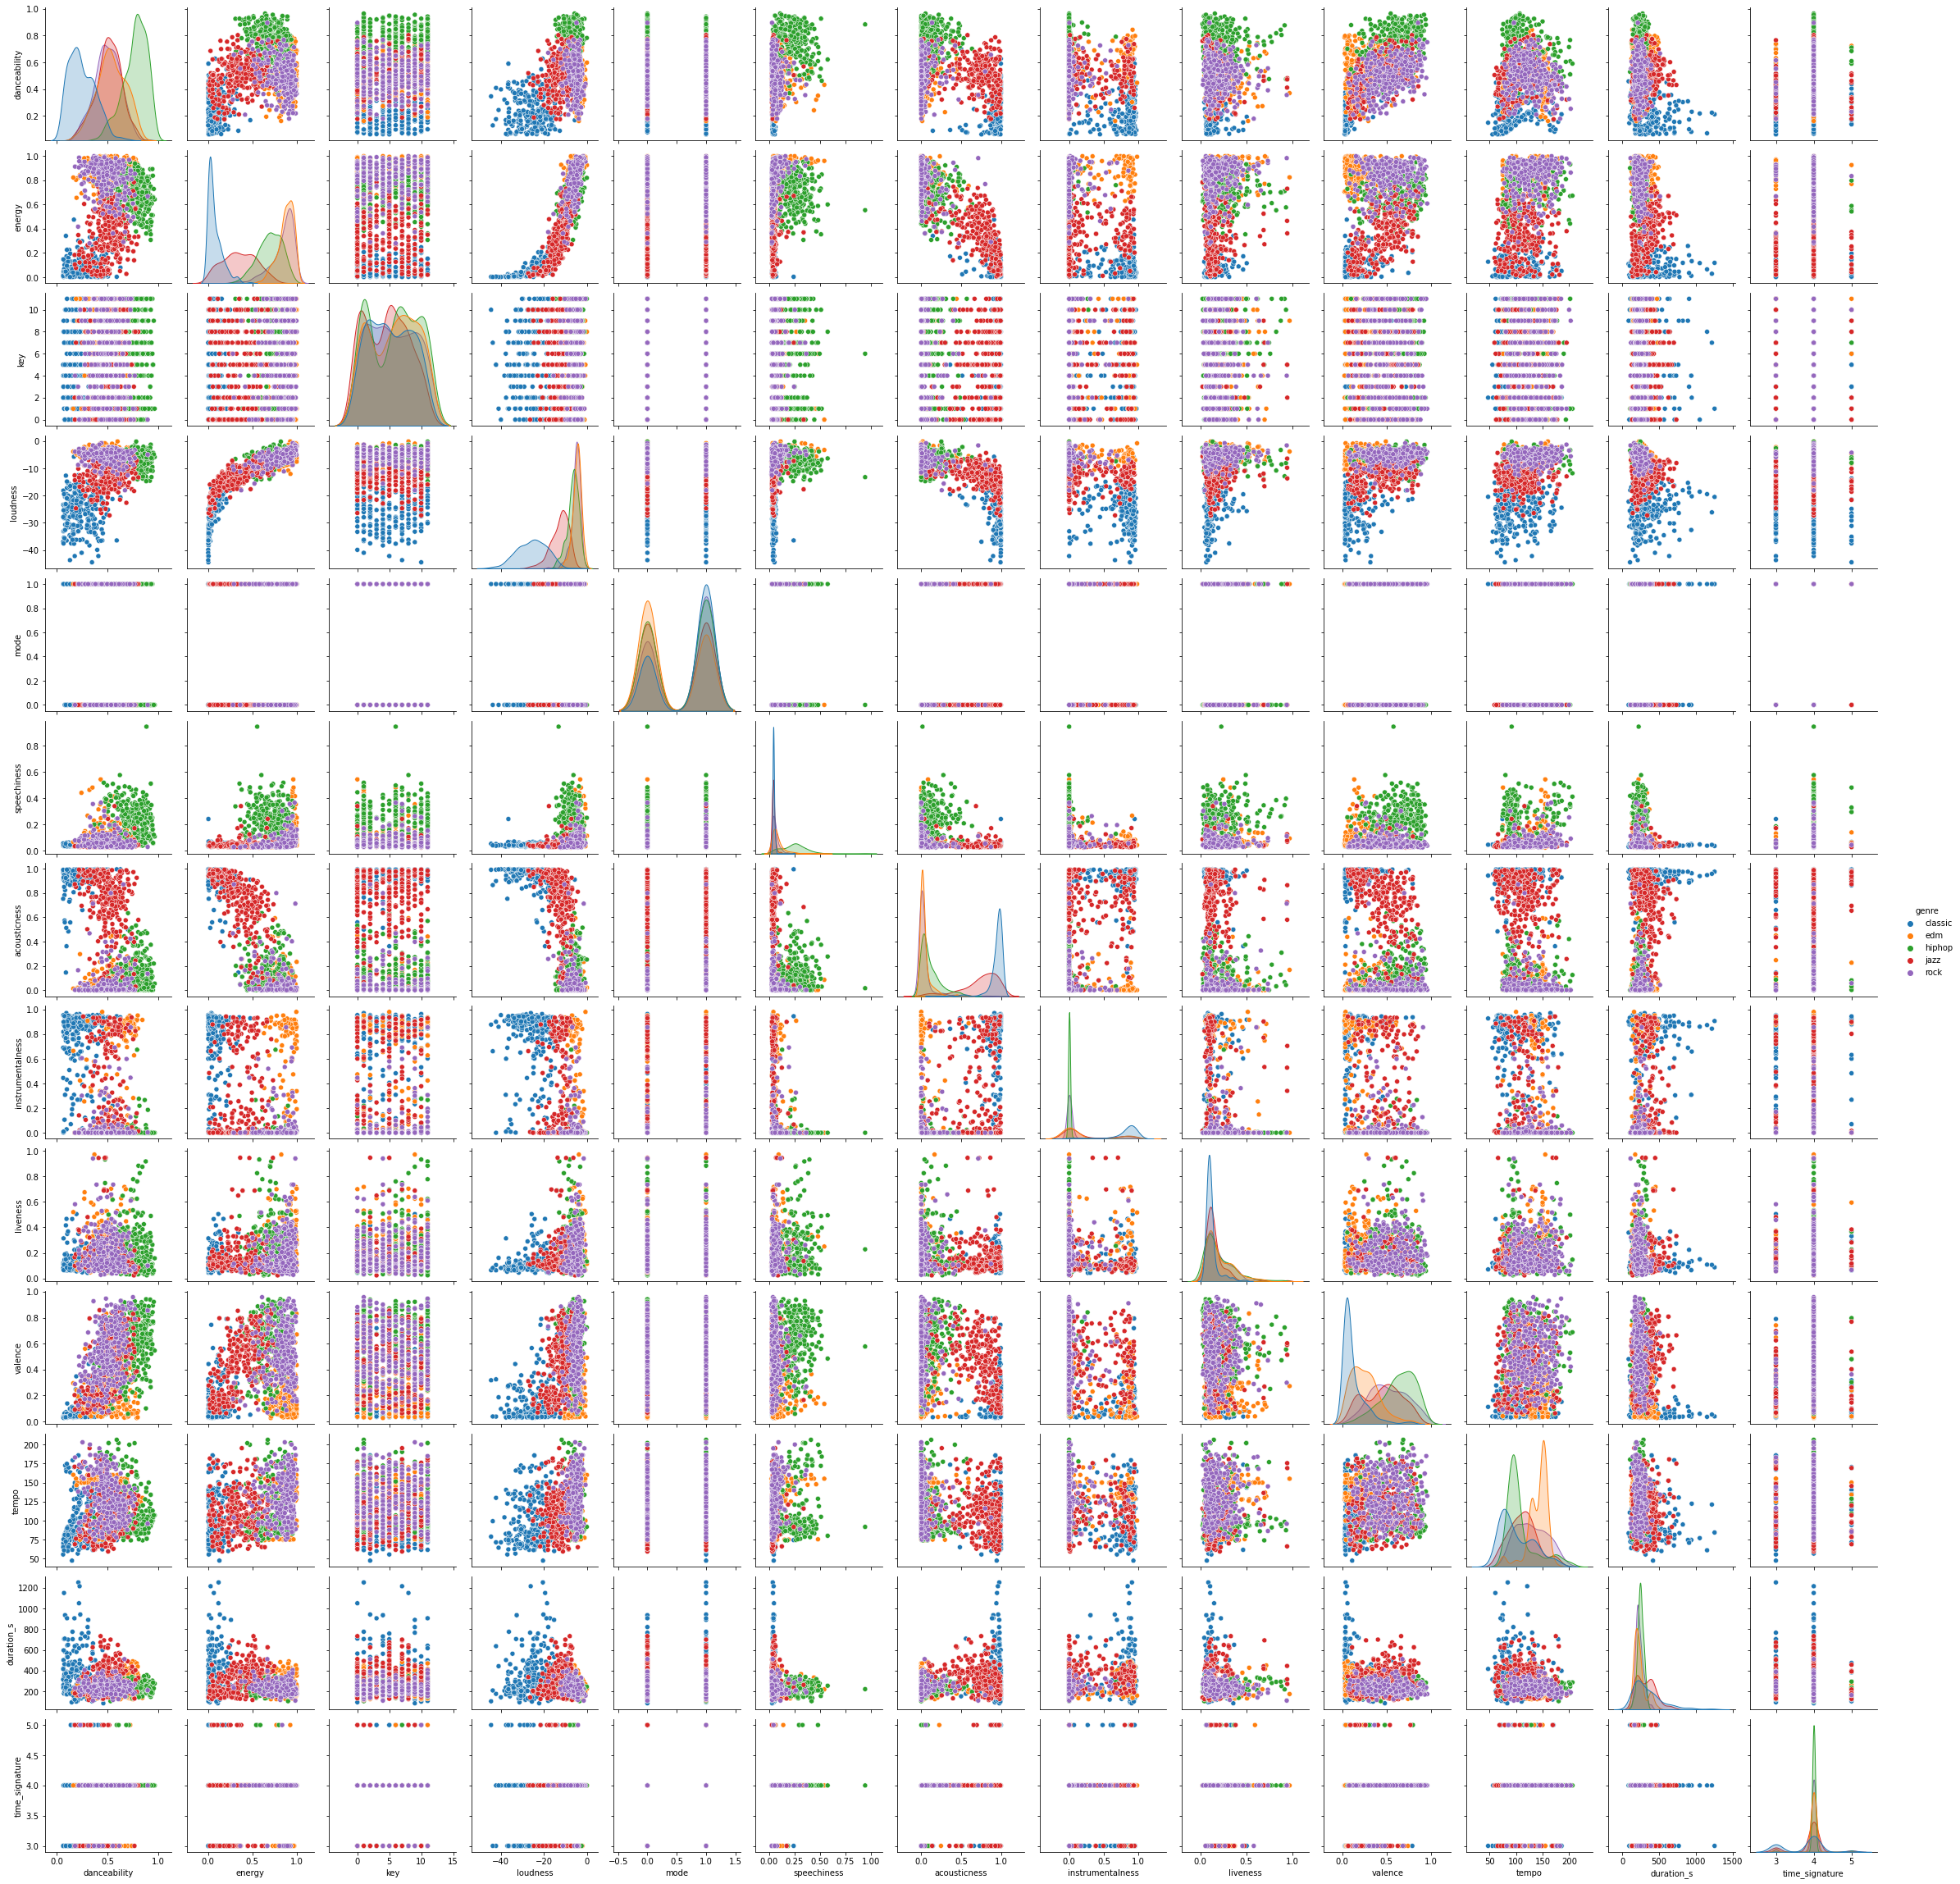

In [26]:
sns.pairplot(data=data, hue="genre")

## Preprocessing

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_s,time_signature
0,0.1930,0.11600,9,-25.718,1,0.0608,0.98600,0.918000,0.5050,0.0836,143.301,242.467,3
1,0.3210,0.00611,4,-38.341,0,0.0362,0.99500,0.908000,0.0900,0.0693,104.311,205.493,4
2,0.4480,0.00520,4,-36.512,1,0.0564,0.99500,0.880000,0.0698,0.0398,62.171,369.027,4
3,0.4250,0.03630,1,-21.629,0,0.0686,0.99100,0.001090,0.2500,0.7450,78.991,143.777,4
4,0.0748,0.04420,0,-19.183,1,0.0426,0.95700,0.940000,0.1160,0.0369,79.092,348.907,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185,0.7610,0.91700,8,-4.083,0,0.1390,0.00959,0.008480,0.0781,0.7820,131.955,151.368,4
1186,0.4360,0.70900,10,-7.185,0,0.1030,0.02290,0.005670,0.0768,0.2830,127.508,171.797,4
1187,0.7390,0.87000,2,-4.300,1,0.0396,0.01350,0.000072,0.0760,0.7410,125.022,126.720,3
1188,0.6310,0.91700,1,-3.301,0,0.2070,0.01370,0.000023,0.1000,0.1950,140.008,158.250,4


## Model Selection

In [27]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

X = data.iloc[:,:13]
y = data.genre

print(cross_val_score(RandomForestClassifier(n_estimators=1000), X, y, cv=10))

[0.92666667 0.90666667 0.91333333 0.93333333 0.92       0.92
 0.91275168 0.9261745  0.88590604 0.8590604 ]


In [139]:
from sklearn.model_selection import GridSearchCV

paramGrid =  {
            'max_depth': [4,10,20,40],
            'n_estimators': [100,500,1000]
           }

id_search = GridSearchCV(
            estimator = RandomForestClassifier(), 
            param_grid = paramGrid, 
            cv = 5, 
            n_jobs = -1, 
            verbose = 1
        )

id_search.fit(X, y)

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [10, 20, 30, 40],
                         'max_features': [2, 3, 4, 5],
                         'min_samples_leaf': [3, 4, 5, 8],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300, 400, 500, 600, 700,
                                          800, 900]},
             verbose=1)

In [142]:
id_search.best_params_

{'bootstrap': True,
 'max_depth': 40,
 'max_features': 4,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 100}

## Train/Test split

In [62]:
data_x = data.iloc[:,:13]

x_train, x_test, y_train, y_test = train_test_split(data_x, data.genre, test_size=0.33, stratify=data.genre)

## Feature selection

In [191]:
from sklearn.feature_selection import SelectKBest, SelectPercentile, chi2, f_classif, mutual_info_classif
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split

In [192]:
categorical_features = {'key', 'mode', 'time_signature'}
numeric_features = set(x_test.columns) - categorical_features

### Chi-square Test

In [197]:
chi2_statistics, chi2_p_scores = chi2(x_train[categorical_features],y_train)
chi2_scores = pd.Series(chi2_statistics, index=categorical_features)
chi2_scores.sort_values(ascending=False)

key               33.870773
mode               9.939228
time_signature     2.511406
dtype: float64

### ANOVA f Test

In [198]:
anova_statistics, anova_p_scores = f_classif(x_train[numeric_features], y_train)
anova_scores = pd.Series(anova_statistics, index=numeric_features)
anova_scores.sort_values(ascending=False)

acousticness        1821.335312
energy              1310.576189
loudness            1022.777462
danceability         423.662584
speechiness          312.476202
instrumentalness     304.661877
valence              249.890528
tempo                 58.902654
duration_ms           46.050166
liveness              17.338576
dtype: float64

### Mutual Information

In [199]:
discrete_features_indices = [list(x_test.columns).index(x) for x in categorical_features]
mutual_statistics = mutual_info_classif(x_train, y_train, discrete_features=discrete_features_indices)
mutual_scores = pd.Series(mutual_statistics, index=x_train.columns)
mutual_scores.sort_values(ascending=False)

energy              0.764791
acousticness        0.749461
loudness            0.682575
danceability        0.507804
speechiness         0.458202
tempo               0.426068
valence             0.380121
instrumentalness    0.367982
duration_ms         0.184188
liveness            0.107330
key                 0.090991
time_signature      0.071270
mode                0.011266
dtype: float64

### Tree-based feature importances

acousticness        0.170084
energy              0.130905
loudness            0.121399
danceability        0.120746
speechiness         0.114540
valence             0.107164
instrumentalness    0.080107
tempo               0.061321
duration_ms         0.051140
liveness            0.022128
key                 0.012846
mode                0.003853
time_signature      0.003767
dtype: float64


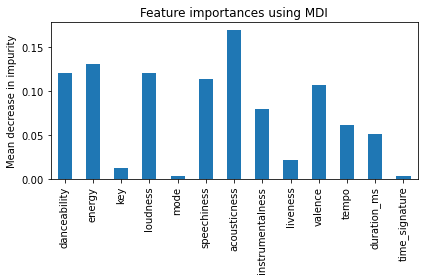

In [200]:
clf = RandomForestClassifier(n_estimators=1000)
clf = clf.fit(x_train, y_train)

forest_importances = pd.Series(clf.feature_importances_, index=x_train.columns)
fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

print(forest_importances.sort_values(ascending=False))